In [ ]:
!pip install evaluate
!pip install albumentations
!pip install transformers
!pip install accelerate
!pip install xmltodict

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import json
from typing import List

import pandas as pd
import cv2
import torch
import seaborn as sns
from torch import nn
import xmltodict
import evaluate
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter



from transformers import Trainer, TrainingArguments
from transformers import SegformerImageProcessor
from transformers import SegformerForSemanticSegmentation
from torchvision.transforms import ColorJitter, RandomRotation
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
# Create train and test sets
train_folder = "drive/MyDrive/defect/pcb/train/images/"
test_folder = "drive/MyDrive/defect/pcb/validation/images/"

train_img_paths = sorted([train_folder + f for f in os.listdir(train_folder) if f.endswith("jpg")])
test_img_paths = sorted([test_folder + f for f in os.listdir(test_folder) if f.endswith("jpg")])
train_xml_paths = [f[:-3] + "xml" for f in train_img_paths]
test_xml_paths = [f[:-3] + "xml" for f in test_img_paths]

train_ds = {"image_paths": train_img_paths, "xml_paths": train_xml_paths}
test_ds = {"image_paths": test_img_paths, "xml_paths": test_xml_paths}

In [5]:
id_cat_map = {"Short_circuit": 1, "Dry_joint": 2, "Incorrect_installation": 3}
color_map = {
  "Short_circuit": (255, 0, 0), "Dry_joint": (0, 255, 0), "Incorrect_installation": (0, 0, 255)}

In [6]:
def process_mask(img_path, xml_path, visualize=False):
    # Read image and init mask
    img = cv2.imread(img_path)

    # Return RGB mask if visualize=True
    num_dim = 3 if visualize else 1
    mask = np.zeros((img.shape[0], img.shape[1], num_dim))

    # Read xml content from the file
    with open(xml_path, "r") as file:
      xml_content = file.read()

    data = xmltodict.parse(xml_content)

    # If has defect mask
    if "object" in data["annotation"]:
        objects = data["annotation"]["object"]

        # Single defects are annotated as a single dict, not a list
        if not isinstance(objects, List):
          objects = [objects]

        for obj in objects:
          defect_type = obj["name"]
          polygon = obj["polygon"]
          poly_keys = list(polygon.keys())

          # Get number of (x, y) pairs - polygon coords
          poly_keys = [int(k[1:]) for k in poly_keys]
          num_poly_points = max(poly_keys)

          # Parse ordered polygon coordinates
          poly_coords = []
          for i in range(1, num_poly_points+1):
              poly_coords.append([
                  int(float(polygon[f"x{i}"])),
                  int(float(polygon[f"y{i}"]))
              ])
          poly_coords = np.array(poly_coords)

          # Draw defect segment on mask
          fill_color = color_map[defect_type] if visualize else id_cat_map[defect_type]
          mask = cv2.fillPoly(mask, pts=[poly_coords], color=fill_color)

    if visualize:
        cv2.imwrite("output.jpg", mask)
        mask = Image.open("output.jpg")

    return mask

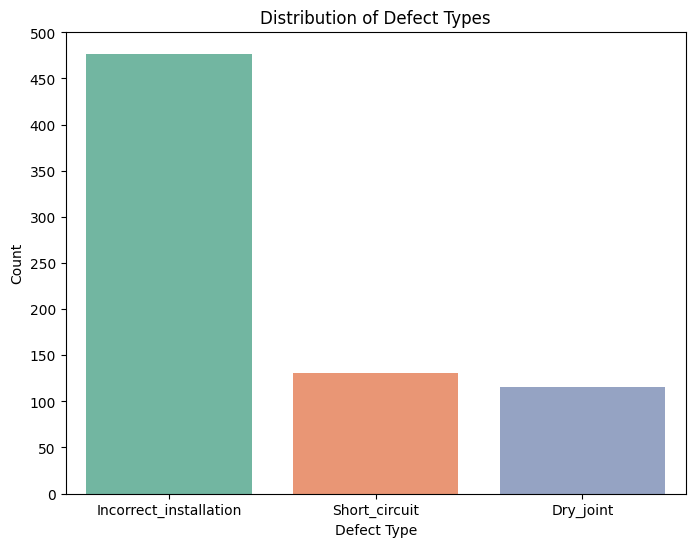

In [7]:
def get_defect_types(xml_paths):
    defect_types = []
    for xml_path in xml_paths:
        with open(xml_path) as f:
            data = xmltodict.parse(f.read())

            if 'object' in data['annotation']:
                objects = data['annotation']['object']
                if not isinstance(objects, list):
                    objects = [objects]
                for obj in objects:
                    defect_types.append(obj['name'])
    return defect_types

defect_types = get_defect_types(train_xml_paths)
defect_counts = Counter(defect_types)

# Convert the defect counts to a pandas DataFrame
defect_df = pd.DataFrame(list(defect_counts.items()), columns=['Defect Type', 'Count'])


plt.figure(figsize=(8, 6))
sns.barplot(x='Defect Type', y='Count', data=defect_df, palette='Set2')
max_count = defect_df['Count'].max()
plt.yticks(range(0, max_count + 50, 50))
plt.title('Distribution of Defect Types')
plt.show()



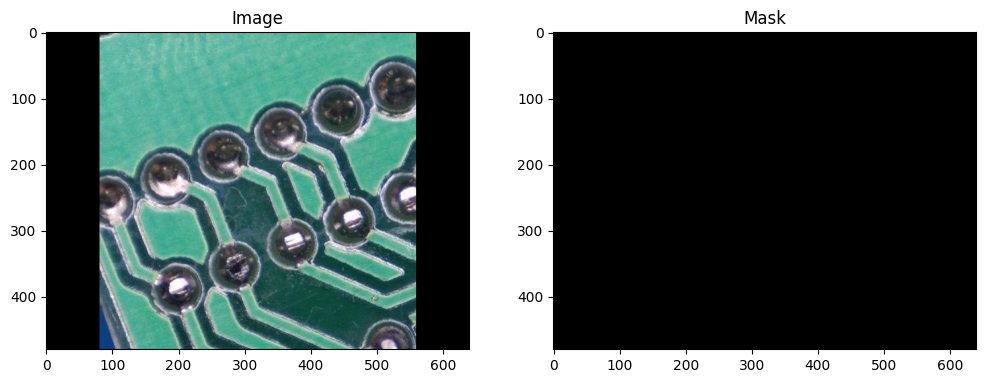

In [8]:
def visualize_data(image_paths, xml_paths, index):
    img_path = image_paths[index]
    xml_path = xml_paths[index]

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = process_mask(img_path, xml_path, visualize=True)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img)
    ax[0].set_title("Image")
    ax[1].imshow(mask)
    ax[1].set_title("Mask")
    plt.show()

# Visualize some random data points
visualize_data(train_img_paths, train_xml_paths, index=85) # For the Incorrect Installation

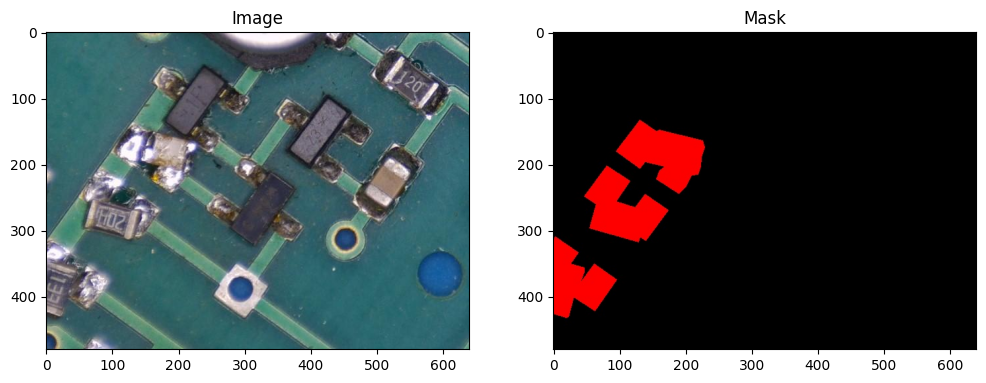

In [9]:
visualize_data(train_img_paths, train_xml_paths, index=101) # For the Short Circuit

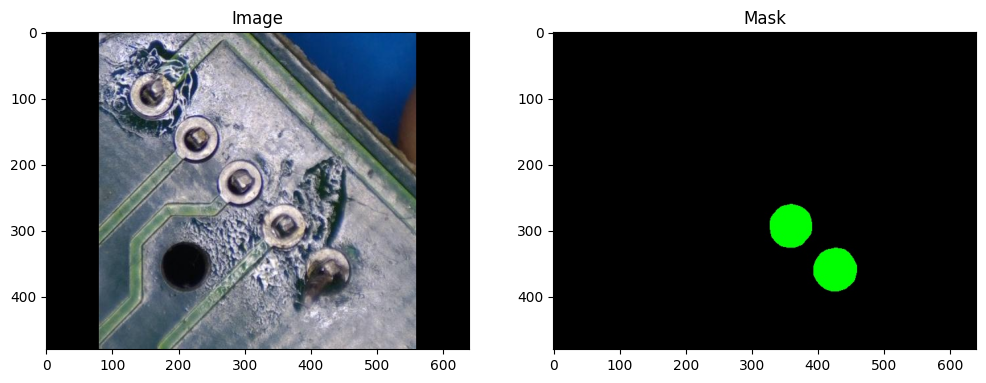

In [10]:
visualize_data(train_img_paths, train_xml_paths, index=24) # For the Dry Joint

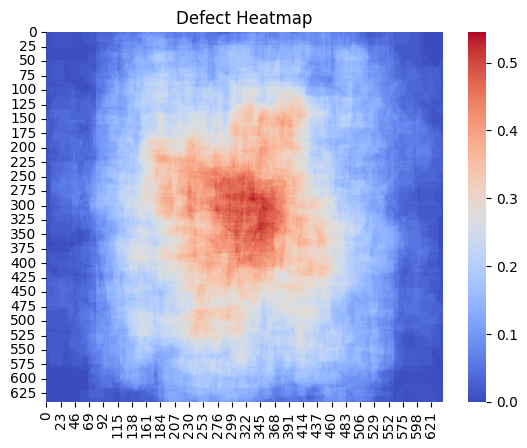

In [11]:
import seaborn as sns

def create_heatmap(xml_paths, img_shape=(640,640)):
    heatmap = np.zeros(img_shape)
    for xml_path in xml_paths:
        mask = process_mask(xml_path.replace(".xml", ".jpg"), xml_path)
        heatmap += cv2.resize(mask, img_shape)
    heatmap /= len(xml_paths)
    sns.heatmap(heatmap, cmap='coolwarm')
    plt.title('Defect Heatmap')
    plt.show()

# Create heatmap for the training data
create_heatmap(train_xml_paths)


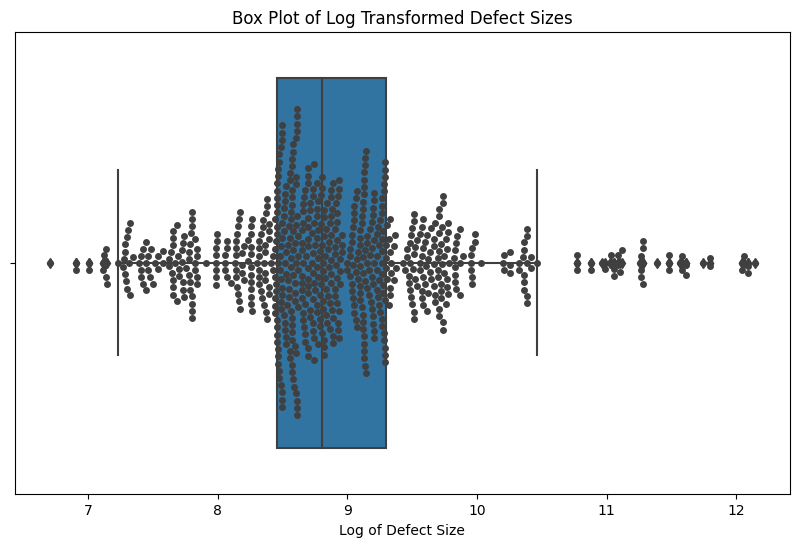

In [12]:
import numpy as np

def get_defect_sizes(xml_paths):
    sizes = []
    for xml_path in xml_paths:
        with open(xml_path) as f:
            data = xmltodict.parse(f.read())
            objects = []
            if 'object' in data['annotation']:
                objects = data['annotation']['object']
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj['bndbox']
                width = int(bndbox['xmax']) - int(bndbox['xmin'])
                height = int(bndbox['ymax']) - int(bndbox['ymin'])
                sizes.append(width * height)
    return sizes

defect_sizes = get_defect_sizes(train_xml_paths)

# Log transform the defect sizes to handle large outliers
log_defect_sizes = np.log1p(defect_sizes)

plt.figure(figsize=(10, 6))
sns.boxplot(x=log_defect_sizes)
sns.swarmplot(x=log_defect_sizes, color=".25")

plt.xlabel('Log of Defect Size')
plt.title('Box Plot of Log Transformed Defect Sizes')
plt.show()



In [13]:
# Calculate the original defect sizes for a range of x-axis values
x_values = np.array([7, 8, 9, 10, 11, 12])
original_defect_sizes = np.expm1(x_values)

original_defect_sizes


array([  1095.63315843,   2979.95798704,   8102.08392758,  22025.46579481,
        59873.1417152 , 162753.791419  ])

In [14]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5)
])

preprocessor = SegformerImageProcessor()

class DefectSegmentationDataset(Dataset):
  def __init__(self, dataset, mode):
    self.image_paths = dataset["image_paths"]
    self.xml_paths = dataset["xml_paths"]

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    # Read image
    image = cv2.imread(self.image_paths[idx])

    # Get mask
    mask = process_mask(self.image_paths[idx], self.xml_paths[idx])
    mask = mask.squeeze()
    mask = Image.fromarray(mask.astype("uint8"), "L")

    # Return preprocessed inputs
    inputs = preprocessor(image, mask, ignore_index=None, return_tensors="pt")
    inputs["pixel_values"] = inputs["pixel_values"].squeeze(0)
    inputs["labels"] = inputs["labels"].squeeze(0)
    return inputs

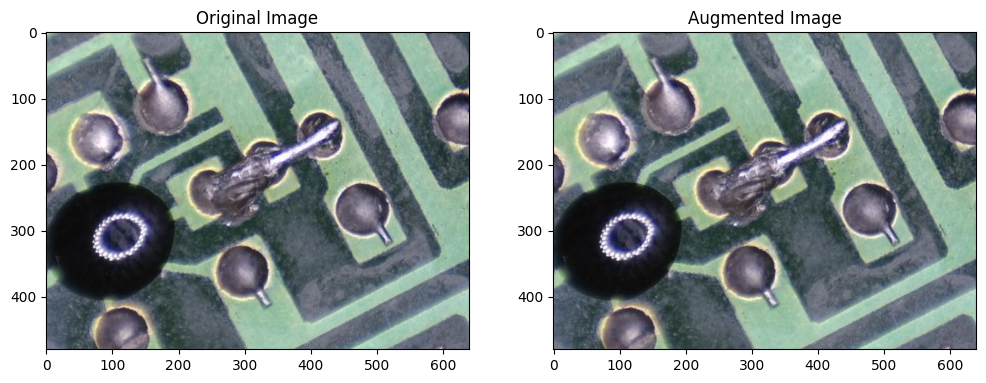

In [15]:
def visualize_augmentations(image_paths, index):
    img_path = image_paths[index]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    augmented = transform(image=img)
    img_augmented = augmented['image']

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    ax[1].imshow(img_augmented)
    ax[1].set_title("Augmented Image")
    plt.show()

# Visualize augmentations
visualize_augmentations(train_img_paths, index=8)


In [16]:
train_data = DefectSegmentationDataset(train_ds, "train")
test_data = DefectSegmentationDataset(test_ds, "test")

# The __getitem__ method is executed at each iteration of the for loop
for sample in train_data:
  print(sample["pixel_values"].shape)
  print(sample["labels"].shape)
  break

torch.Size([3, 512, 512])
torch.Size([512, 512])


In [17]:
id2label = {0: "background", 1: "Short_circuit", 2: "Dry_joint", 3: "Incorrect_installation"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)

# Pretrained model name
pretrained_model_name = "nvidia/mit-b0"

# Load the pretrained model
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.bias', 'decode_head.classifier.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.classifier.bias', 'decode_head.batch_norm.weight', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.running_mean']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Training parameters
epochs = 50
lr = 0.00001
batch_size = 1

# Training arguments
training_args = TrainingArguments(
    "segformer-b0-finetuned-pcb-outputs",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=500,
    eval_steps=250,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
)

In [19]:
metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)

    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()

    # currently using _compute instead of compute
    # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
    metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=None,
            reduce_labels=preprocessor.do_reduce_labels,
        )

    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    return metrics

In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Background,Accuracy Short Circuit,Accuracy Dry Joint,Accuracy Incorrect Installation,Iou Background,Iou Short Circuit,Iou Dry Joint,Iou Incorrect Installation
250,0.969300,0.930318,0.286749,0.509769,0.848643,0.854842,0.057323,0.265874,0.861037,0.846412,0.035399,0.021093,0.244091
500,0.637700,0.609876,0.343058,0.441869,0.933614,0.952626,0.055376,0.046026,0.713448,0.933636,0.051937,0.018337,0.368322
750,0.481100,0.436262,0.353889,0.409003,0.954563,0.979148,0.023528,0.000000,0.633334,0.954986,0.023404,0.000000,0.437167
1000,0.452200,0.319502,0.353571,0.410474,0.955929,0.979369,0.001511,0.000000,0.661015,0.956223,0.001511,0.000000,0.456552
1250,0.238400,0.276116,0.357579,0.424767,0.954025,0.974915,0.016829,0.000000,0.707325,0.954421,0.016580,0.000000,0.459315
1500,0.149800,0.213859,0.358088,0.402326,0.959960,0.985518,0.000000,0.000000,0.623786,0.960278,0.000000,0.000000,0.472072
1750,0.137200,0.190207,0.363334,0.432052,0.957044,0.975996,0.000272,0.000000,0.751940,0.957282,0.000272,0.000000,0.495782
2000,0.228900,0.164058,0.371631,0.429991,0.961076,0.981141,0.004997,0.000000,0.733826,0.961390,0.004948,0.000000,0.520186
2250,0.067300,0.152506,0.373290,0.427322,0.962120,0.982845,0.004452,0.000000,0.721990,0.962288,0.004378,0.000000,0.526493
2500,0.106200,0.140409,0.372876,0.433286,0.961383,0.980622,0.001348,0.000000,0.751175,0.961646,0.001343,0.000000,0.528516


Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Background,Accuracy Short Circuit,Accuracy Dry Joint,Accuracy Incorrect Installation,Iou Background,Iou Short Circuit,Iou Dry Joint,Iou Incorrect Installation
250,0.969300,0.930318,0.286749,0.509769,0.848643,0.854842,0.057323,0.265874,0.861037,0.846412,0.035399,0.021093,0.244091
500,0.637700,0.609876,0.343058,0.441869,0.933614,0.952626,0.055376,0.046026,0.713448,0.933636,0.051937,0.018337,0.368322
750,0.481100,0.436262,0.353889,0.409003,0.954563,0.979148,0.023528,0.000000,0.633334,0.954986,0.023404,0.000000,0.437167
1000,0.452200,0.319502,0.353571,0.410474,0.955929,0.979369,0.001511,0.000000,0.661015,0.956223,0.001511,0.000000,0.456552
1250,0.238400,0.276116,0.357579,0.424767,0.954025,0.974915,0.016829,0.000000,0.707325,0.954421,0.016580,0.000000,0.459315
1500,0.149800,0.213859,0.358088,0.402326,0.959960,0.985518,0.000000,0.000000,0.623786,0.960278,0.000000,0.000000,0.472072
1750,0.137200,0.190207,0.363334,0.432052,0.957044,0.975996,0.000272,0.000000,0.751940,0.957282,0.000272,0.000000,0.495782
2000,0.228900,0.164058,0.371631,0.429991,0.961076,0.981141,0.004997,0.000000,0.733826,0.961390,0.004948,0.000000,0.520186
2250,0.067300,0.152506,0.373290,0.427322,0.962120,0.982845,0.004452,0.000000,0.721990,0.962288,0.004378,0.000000,0.526493
2500,0.106200,0.140409,0.372876,0.433286,0.961383,0.980622,0.001348,0.000000,0.751175,0.961646,0.001343,0.000000,0.528516


TrainOutput(global_step=16600, training_loss=0.109512633263212, metrics={'train_runtime': 2290.0319, 'train_samples_per_second': 7.249, 'train_steps_per_second': 7.249, 'total_flos': 2.910043225718784e+17, 'train_loss': 0.109512633263212, 'epoch': 50.0})

## Inference

In [43]:
processor = SegformerImageProcessor()
model = SegformerForSemanticSegmentation.from_pretrained("segformer-b0-finetuned-pcb-outputs/checkpoint-16500")
model.eval()

test_image = Image.open(test_ds["image_paths"][6])
inputs = processor(images=test_image, return_tensors="pt")

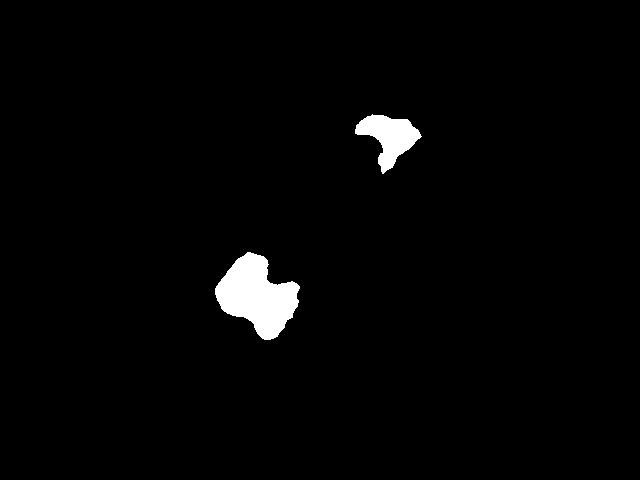

In [44]:
# Inference
with torch.no_grad():
    outputs = model(**inputs)

# Postprocess mask proposals to get the final / refined segmentation mask
semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[test_image.size[::-1]])[0]
semantic_map = np.uint8(semantic_map)

# Replace category ids with color values for visualization
semantic_map[semantic_map==1] = 255
semantic_map[semantic_map==2] = 195
semantic_map[semantic_map==3] = 135
semantic_map[semantic_map==4] = 75
Image.fromarray(semantic_map).convert("L")